In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.rcParams['image.interpolation'] = 'nearest'


%load_ext autoreload
%autoreload 2

[autoreload of tensorflow.python.platform failed: Traceback (most recent call last):
  File "/home/jy/.pyenv/versions/final/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jy/.pyenv/versions/final/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/home/jy/.pyenv/versions/final/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/jy/.pyenv/versions/final/lib/python3.5/importlib/__init__.py", line 159, in reload
    name=parent_name) from None
ImportError: parent 'tensorflow.python' not in sys.modules
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from cbir.model import get_model
from cbir.features import extract_raw_features
from cbir.utils import load_image, get_list, load_npy_files, covert_data_format
from cbir.utils import run_feature_processing_pipeline, get_list_set
from cbir.utils import result_ap, result_precision, compute_ap
from cbir.crow import apply_crow_aggregation
from cbir.rmac import apply_rmac_aggregation
from cbir.pwa import PWA, get_discriminative_fm

from cbir.query import compute_cosin_distance, simple_query_expansion

model = get_model()
# dataset_img_path='/home/jy/dataset/fabric_dataset/out'
# raw_out_path='/home/jy/results/new/raw'
# crow_out_path='/home/jy/results/new/crow'
# rmac_out_path='/home/jy/results/new/rmac'
# pwa_out_path='/home/jy/results/new/pwa'
# gt_file = '/home/jy/dataset/fabric_dataset/gt_new.txt'
# query_img_path = '/home/jy/dataset/fabric_dataset/new'
# query_out_path='/home/jy/results/new/query'
target_size=(512,512)
dataset_img_path='/home/jy/dataset/oxbuild'
raw_out_path='/home/jy/results/ox/raw'
# crow_out_path='/home/jy/results/new/crow'
# rmac_out_path='/home/jy/results/new/rmac'
# pwa_out_path='/home/jy/results/new/pwa'
gt_file = '/home/jy/dataset/fabric_dataset/gt_new.txt'
query_img_path = '/home/jy/dataset/fabric_dataset/new'
query_out_path='/home/jy/results/new/query'



In [7]:


img_list = get_list(dataset_img_path)
print('total number: %d ' % len(img_list))
t_start = time.time()
for i,file_path in enumerate(img_list):
    if i != 0 and i % 100 == 0:
        print('process %.2f .... time elapse: %.2f s' % ((i/(len(img_list)))*100,
                                                      (time.time()-t_start)))
        #print(file_path)    
    
    img = load_image(file_path,target_size)
    # layer block5
    raw_feature = extract_raw_features(model,img)
    np.save(os.path.join(raw_out_path,os.path.basename(file_path).split('.')[0]), raw_feature)
    
#     #print(cvt_raw_feature.shape)
#     cvt_raw_feature = covert_data_format(raw_feature)
#     # crow feature
#     crow_feature = apply_crow_aggregation(cvt_raw_feature)
#     #print(crow_feature.shape,crow_feature[0,:10])
#     np.save(os.path.join(crow_out_path,os.path.basename(file_path).split('.')[0]), crow_feature)

#     # rmac feature
#     rmac_feature = apply_rmac_aggregation(cvt_raw_feature)
#     #print(rmac_feature.shape,rmac_feature[1,:10])
#     np.save(os.path.join(rmac_out_path,os.path.basename(file_path).split('.')[0]), rmac_feature)
    
print('total time : %f s' % ((time.time()-t_start),))
del t_start
del img_list


total number: 5063 
process 1.98 .... time elapse: 227.73 s
process 3.95 .... time elapse: 414.20 s
process 5.93 .... time elapse: 604.16 s
process 7.90 .... time elapse: 790.72 s
process 9.88 .... time elapse: 977.66 s
process 11.85 .... time elapse: 1166.57 s
process 13.83 .... time elapse: 1356.24 s
process 15.80 .... time elapse: 1537.90 s
process 17.78 .... time elapse: 1714.50 s
process 19.75 .... time elapse: 1891.13 s
process 21.73 .... time elapse: 2065.39 s
process 23.70 .... time elapse: 2240.81 s
process 25.68 .... time elapse: 2416.08 s
process 27.65 .... time elapse: 2589.34 s
process 29.63 .... time elapse: 2760.54 s
process 31.60 .... time elapse: 2931.89 s
process 33.58 .... time elapse: 3107.22 s
process 35.55 .... time elapse: 3281.74 s
process 37.53 .... time elapse: 3455.45 s
process 39.50 .... time elapse: 3628.99 s
process 41.48 .... time elapse: 3801.25 s
process 43.45 .... time elapse: 3974.98 s
process 45.43 .... time elapse: 4149.23 s
process 47.40 .... time 

In [5]:

# load raw features
t_start = time.time()
raw_file_list = get_list(raw_out_path,'npy')

raw_features,raw_files = load_npy_files(raw_file_list)

print('load time %f s' % (time.time() - t_start,))
print(raw_features.shape, raw_files[1])

del t_start
del raw_file_list


successful loading of npy file !!!
load time 19.978814 s
(4506, 16, 16, 512) 1A0035D13A1B_0_2642


In [6]:


#pwa
t_start = time.time()
channel_weights = get_discriminative_fm(raw_features)
#print(channel_weights.shape)
#del raw_features

for i,f in enumerate(raw_features):
    cvt_raw_feature = covert_data_format(f)  # C x H x W
    pwa_feature = PWA(cvt_raw_feature, channel_weights)
    np.save(os.path.join(pwa_out_path,os.path.basename(raw_files[i])), pwa_feature)
    #print(pwa_feature.shape)
    #print(os.path.basename(raw_files[i]))

            
print('time %f s' % (time.time() - t_start,))

del t_start
del raw_features


time 39.098953 s


In [7]:
#pca
# load raw features
d=4096
t_start = time.time()
pwa_file_list = get_list(pwa_out_path,'npy')

pwa_features,pwa_files = load_npy_files(pwa_file_list)

print('load time %f s' % (time.time() - t_start,))
print(pwa_features.shape, pwa_files[1])

pca_pwa_features, pwa_params = run_feature_processing_pipeline(pwa_features, d=d)

print(pca_pwa_features.shape,pwa_params)

del t_start
del pwa_file_list

successful loading of npy file !!!
load time 1.855692 s
(4506, 12288) 1A0035D13A1B_0_2642
(4506, 4096) {'pca': PCA(copy=False, iterated_power='auto', n_components=4096, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)}


In [ ]:
crow_file_list = get_list(crow_out_path,'npy')
crow_features,crow_files = load_npy_files(crow_file_list)

del crow_file_list

rmac_file_list = get_list(rmac_out_path,'npy')
rmac_features,rmac_files = load_npy_files(rmac_file_list)

del rmac_file_list

successful loading of npy file !!!


In [18]:
#query features

query_lists = get_list(query_img_path)
#query_raw_features=np.zeros((0,16,16,512))
query_crow_features=np.zeros((0,512))
query_rmac_features=np.zeros((0,512))
query_pwa_features=np.zeros((0,12288))
query_names=list()
for i in query_lists:
    img = load_image(i,target_size)
    query_names.append(os.path.basename(i).split('.')[0])
    raw_feature = extract_raw_features(model,img)
    cvt_raw_feature = covert_data_format(raw_feature)
    crow_feature = apply_crow_aggregation(cvt_raw_feature)
    rmac_feature = apply_rmac_aggregation(cvt_raw_feature)
    pwa_feature = PWA(cvt_raw_feature, channel_weights)
    #query_raw_features = np.vstack((query_raw_features,raw_feature))
    np.save(os.path.join(query_out_path,os.path.basename(i).split('.')[0]), raw_feature)
    query_crow_features = np.vstack((query_crow_features,crow_feature))
    query_rmac_features = np.vstack((query_rmac_features,rmac_feature))
    query_pwa_features = np.vstack((query_pwa_features,pwa_feature))
    
#print(query_raw_features.shape)
print(query_crow_features.shape)
print(query_rmac_features.shape)
print(query_pwa_features.shape)
print(len(query_names),query_names[0])

(751, 512)
(751, 512)
(751, 12288)
751 1A0035D13A1B


In [ ]:
#visual

indxs=channel_weights
query_file_list = get_list(query_out_path,'npy')
query_features,query_files = load_npy_files(query_file_list)

(3024, 3024, 3)
(16, 16, 512)
2A4043X63A1A


(-0.5, 511.5, 511.5, -0.5)

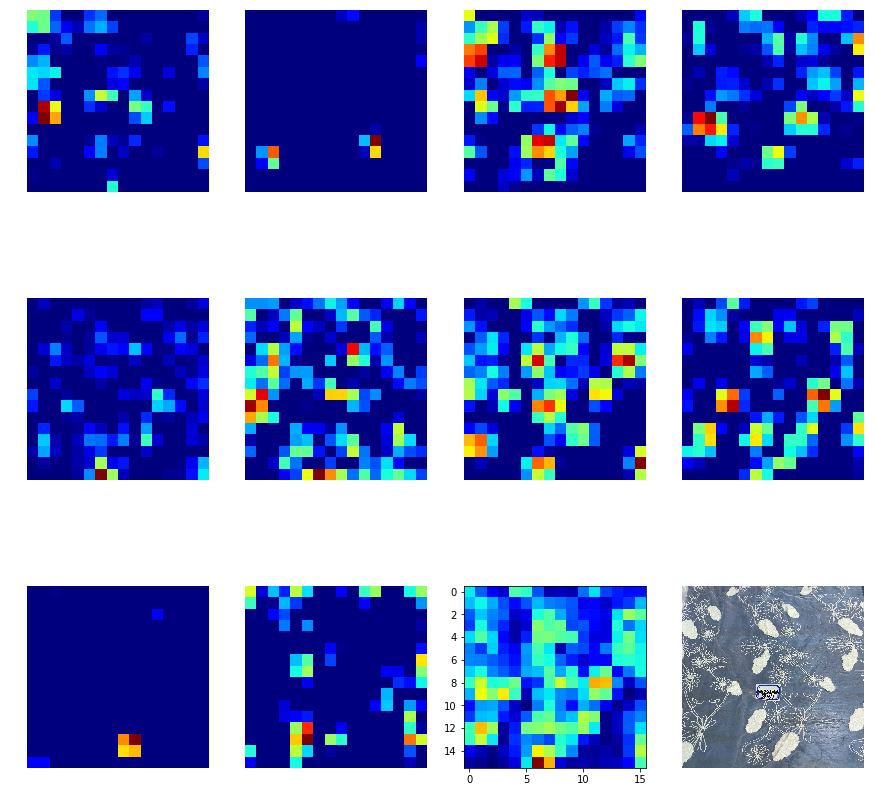

In [28]:
import cv2

indx = 340  #position
indx2 = 3
test_img = cv2.imread(os.path.join(query_img_path,query_files[indx]+'.jpg'))
print(test_img.shape)
fig = plt.figure(1,figsize=(15,15))
plt.axis('off')
print(query_raw_features[0].shape)
print(query_files[indx])
#tmp = query_raw_features[indx][...,indxs[indx2]]
#tmp = np.sum(tmp,axis=-1)
#print(tmp.shape)
#plt.imshow(tmp, cmap='jet', alpha=0.8)
tmp_feature = query_raw_features[indx]
for i, f in enumerate(indxs[:10]):
    plt.subplot(3,4,i+1)
    plt.axis('off')
    plt.imshow(tmp_feature[...,f], cmap='jet')

plt.subplot(3,4,11).imshow(query_raw_features[indx][...,indxs[:10]].sum(-1), cmap='jet')
plt.subplot(3,4,12).imshow(cv2.resize(test_img,target_size))
plt.axis('off')
#print(tmp_feature[...,1])

In [9]:

#query_features
query_pca_pwa_features,_ = run_feature_processing_pipeline(query_pwa_features,d=d,params=pwa_params)
print(query_pca_pwa_features.shape)
gt_dict=dict()
with open(gt_file,'r') as f:
    for i in f:
        a,b = i.strip().split(' ')
        gt_dict[a] = b
#print([(k,v) for k,v in sorted(gt_dict.items())][:10])


(751, 4096)


In [61]:

topK=6
rmac_aps=list()
crow_aps=list()
pwa_aps=list()
for i in range(len(query_names)):
    idxs, rank_dists, rank_names = compute_cosin_distance([query_pca_pwa_features[i]], 
                                                          pca_pwa_features, pwa_files)
    pos,neg = get_list_set(query_names[i],gt_dict)
    #ap1 = result_precision(pos,neg,rank_names[:topK])
    #ap2 = result_ap(pos,neg,rank_names[:topK])
    ap = compute_ap(pos,rank_names[:topK])
    #print(ap,ap1,ap2)
    #print(rank_names[:topK])
    #print('    qe %s ap: %f ' % (query_names[i],ap))
    
    idxs1, rank_dists1, rank_names1 = compute_cosin_distance([query_crow_features[i]], 
                                                             crow_features, crow_files)

    ap1 = compute_ap(pos,rank_names1[:topK])
    
    idxs2, rank_dists2, rank_names2 = compute_cosin_distance([query_rmac_features[i]], 
                                                             rmac_features, rmac_files)

    ap = compute_ap(pos,rank_names2[:topK])
    pwa_aps.append(ap)
    crow_aps.append(ap1)
    rmac_aps.append(ap2)
    
print('mAP %f' % (np.array(pwa_aps).sum()/len(pwa_aps),))
print('mAP %f' % (np.array(crow_aps).sum()/len(crow_aps),))
print('mAP %f' % (np.array(rmac_aps).sum()/len(rmac_aps),))


mAP 0.774902
mAP 0.724815
mAP 0.714286
